In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


### Import Libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

### Load Data

In [3]:
df = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")

### Data Exploration

In [4]:
print(df.head())

   id     Podcast_Name Episode_Title  Episode_Length_minutes       Genre  \
0   0  Mystery Matters    Episode 98                     NaN  True Crime   
1   1    Joke Junction    Episode 26                  119.80      Comedy   
2   2   Study Sessions    Episode 16                   73.90   Education   
3   3   Digital Digest    Episode 45                   67.17  Technology   
4   4      Mind & Body    Episode 86                  110.51      Health   

   Host_Popularity_percentage Publication_Day Publication_Time  \
0                       74.81        Thursday            Night   
1                       66.95        Saturday        Afternoon   
2                       69.97         Tuesday          Evening   
3                       57.22          Monday          Morning   
4                       80.07          Monday        Afternoon   

   Guest_Popularity_percentage  Number_of_Ads Episode_Sentiment  \
0                          NaN            0.0          Positive   
1           

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [6]:
print(df.describe())

                  id  Episode_Length_minutes  Host_Popularity_percentage  \
count  750000.000000           662907.000000               750000.000000   
mean   374999.500000               64.504738                   59.859901   
std    216506.495284               32.969603                   22.873098   
min         0.000000                0.000000                    1.300000   
25%    187499.750000               35.730000                   39.410000   
50%    374999.500000               63.840000                   60.050000   
75%    562499.250000               94.070000                   79.530000   
max    749999.000000              325.240000                  119.460000   

       Guest_Popularity_percentage  Number_of_Ads  Listening_Time_minutes  
count                603970.000000  749999.000000           750000.000000  
mean                     52.236449       1.348855               45.437406  
std                      28.451241       1.151130               27.138306  
min        

### Feature Engineering

In [7]:
# Convert categorical features to numerical

# Label encode 'Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment'
categorical_cols = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [8]:
# Handle missing values (imputation)
df['Episode_Length_minutes'].fillna(df['Episode_Length_minutes'].mean(), inplace=True)
df['Guest_Popularity_percentage'].fillna(df['Guest_Popularity_percentage'].mean(), inplace=True)
df['Number_of_Ads'].fillna(df['Number_of_Ads'].mean(), inplace=True)

/tmp/ipykernel_31/737263926.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Episode_Length_minutes'].fillna(df['Episode_Length_minutes'].mean(), inplace=True)
/tmp/ipykernel_31/737263926.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].me

In [9]:
# Select features for prediction
features = [
    'Episode_Length_minutes',
    'Genre',
    'Host_Popularity_percentage',
    'Publication_Day',
    'Publication_Time',
    'Guest_Popularity_percentage',
    'Number_of_Ads',
    'Episode_Sentiment'
    # Add more relevant features if available
]

In [10]:
# Target variable
target = 'Listening_Time_minutes'

In [11]:
# Remove rows with missing values in the target variable
df_cleaned = df[features + [target]].dropna()

In [12]:
X = df_cleaned[features]
y = df_cleaned[target]

### Data Splitting

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Selection and Training

In [14]:
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_predictions = linear_model.predict(X_test)

In [15]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

In [16]:
# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

### Model Evaluation

In [17]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} ---")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared: {r2:.2f}")

In [18]:
evaluate_model(y_test, linear_predictions, "Linear Regression")
evaluate_model(y_test, rf_predictions, "Random Forest Regressor")
evaluate_model(y_test, gb_predictions, "Gradient Boosting Regressor")

--- Linear Regression ---
Mean Squared Error: 178.50
R-squared: 0.76
--- Random Forest Regressor ---
Mean Squared Error: 163.14
R-squared: 0.78
--- Gradient Boosting Regressor ---
Mean Squared Error: 172.45
R-squared: 0.77


### Visualization of Predictions

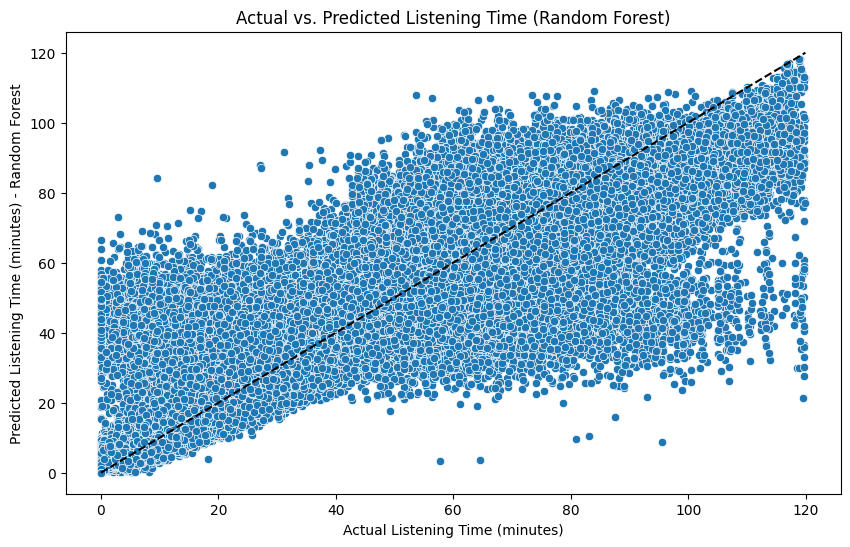

In [19]:
# --- Random Forest Regressor ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=rf_predictions)
plt.xlabel("Actual Listening Time (minutes)")
plt.ylabel("Predicted Listening Time (minutes) - Random Forest")
plt.title("Actual vs. Predicted Listening Time (Random Forest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.show()

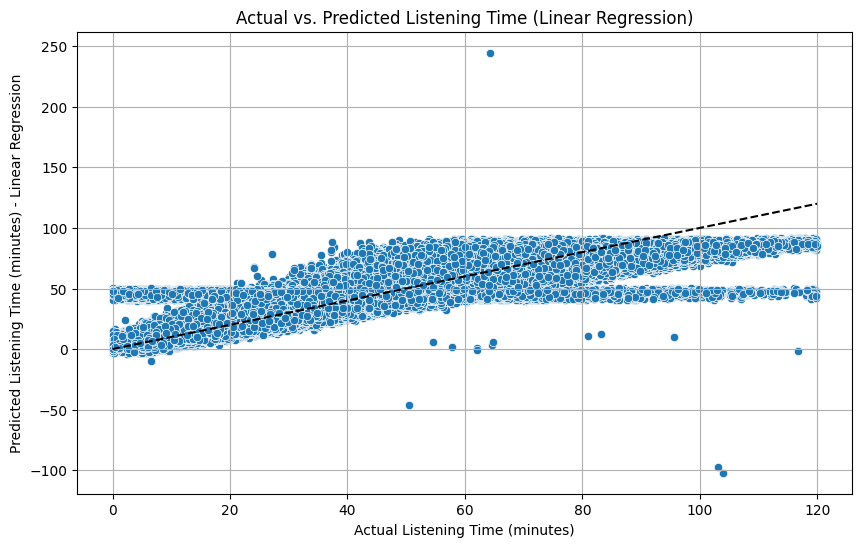

In [20]:
# --- Linear Regression ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=linear_predictions)
plt.xlabel("Actual Listening Time (minutes)")
plt.ylabel("Predicted Listening Time (minutes) - Linear Regression")
plt.title("Actual vs. Predicted Listening Time (Linear Regression)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--') # Diagonal line for perfect predictions
plt.grid(True)
plt.show()

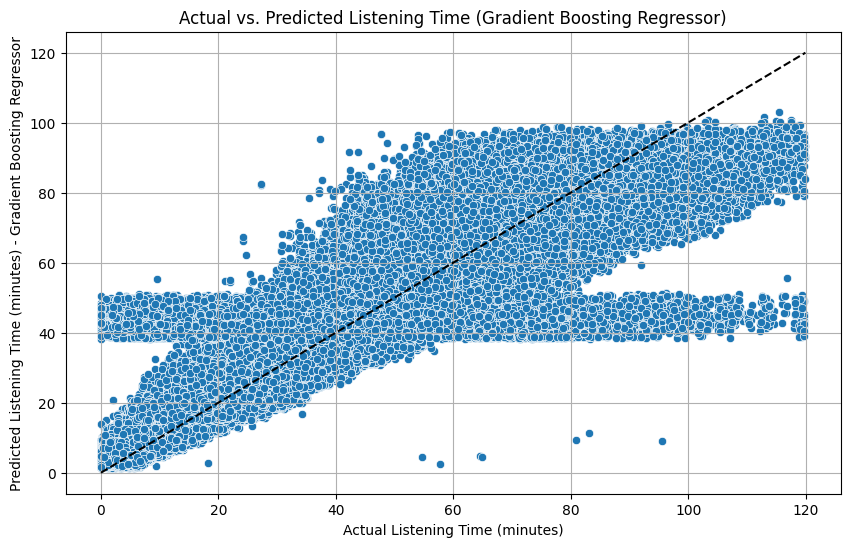

In [21]:
# --- Gradient Boosting Regressor ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=gb_predictions)
plt.xlabel("Actual Listening Time (minutes)")
plt.ylabel("Predicted Listening Time (minutes) - Gradient Boosting Regressor")
plt.title("Actual vs. Predicted Listening Time (Gradient Boosting Regressor)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--') # Diagonal line for perfect predictions
plt.grid(True)
plt.show()

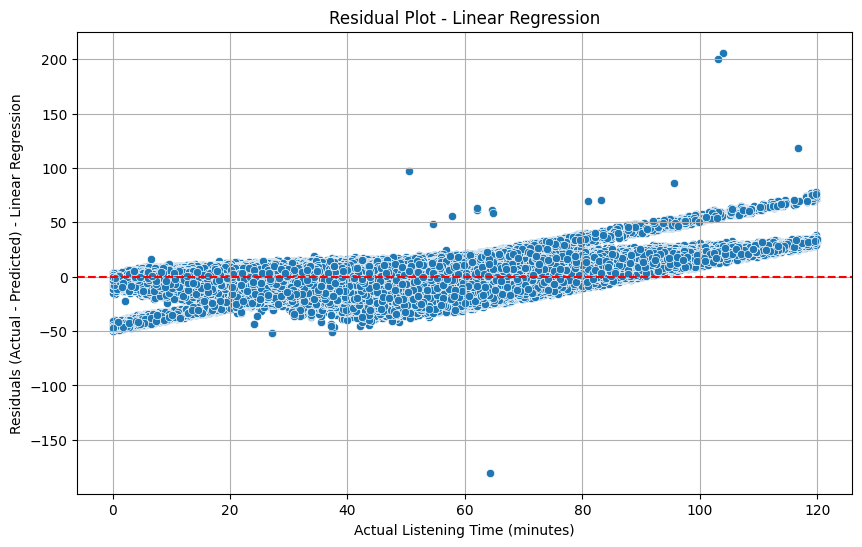

In [22]:
# --- Linear Regression Residuals ---
residuals_linear = y_test - linear_predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals_linear)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual Listening Time (minutes)")
plt.ylabel("Residuals (Actual - Predicted) - Linear Regression")
plt.title("Residual Plot - Linear Regression")
plt.grid(True)
plt.show()

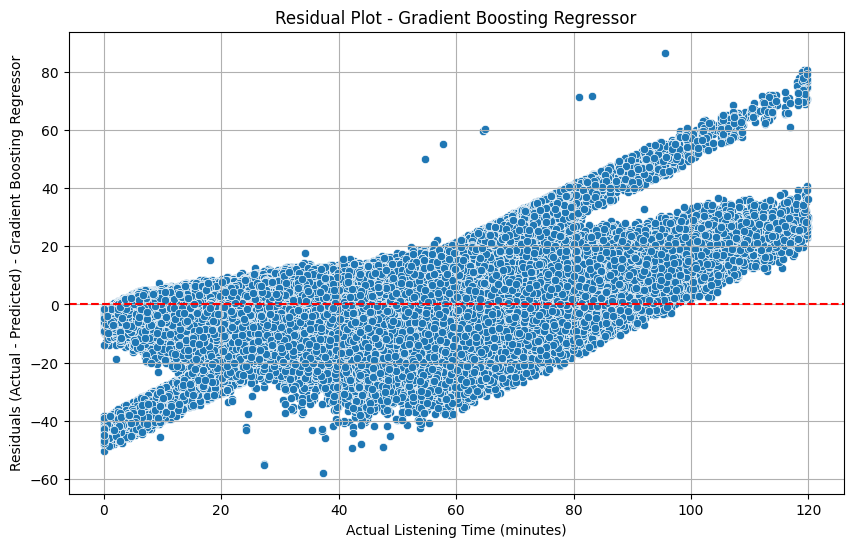

In [23]:
# --- Gradient Boosting Regressor Residuals ---
residuals_gb = y_test - gb_predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals_gb)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual Listening Time (minutes)")
plt.ylabel("Residuals (Actual - Predicted) - Gradient Boosting Regressor")
plt.title("Residual Plot - Gradient Boosting Regressor")
plt.grid(True)
plt.show()

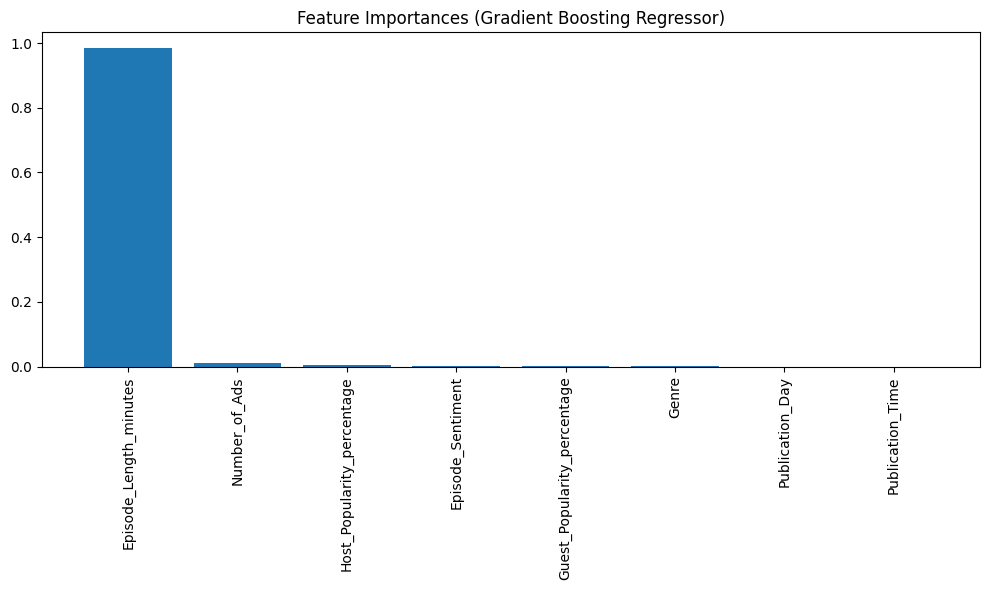

In [24]:
#Feature Importance (for Gradient Boosting Regressor)
feature_importances = gb_model.feature_importances_
feature_names = X_train.columns

sorted_indices = feature_importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Gradient Boosting Regressor)")
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [25]:
df = pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")

In [26]:
print(df.head())

       id         Podcast_Name Episode_Title  Episode_Length_minutes  \
0  750000  Educational Nuggets    Episode 73                   78.96   
1  750001          Sound Waves    Episode 23                   27.87   
2  750002        Joke Junction    Episode 11                   69.10   
3  750003        Comedy Corner    Episode 73                  115.39   
4  750004         Life Lessons    Episode 50                   72.32   

       Genre  Host_Popularity_percentage Publication_Day Publication_Time  \
0  Education                       38.11        Saturday          Evening   
1      Music                       71.29          Sunday          Morning   
2     Comedy                       67.89          Friday          Evening   
3     Comedy                       23.40          Sunday          Morning   
4  Lifestyle                       58.10       Wednesday          Morning   

   Guest_Popularity_percentage  Number_of_Ads Episode_Sentiment  
0                        53.33        

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [27]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           250000 non-null  int64  
 1   Podcast_Name                 250000 non-null  object 
 2   Episode_Title                250000 non-null  object 
 3   Episode_Length_minutes       221264 non-null  float64
 4   Genre                        250000 non-null  object 
 5   Host_Popularity_percentage   250000 non-null  float64
 6   Publication_Day              250000 non-null  object 
 7   Publication_Time             250000 non-null  object 
 8   Guest_Popularity_percentage  201168 non-null  float64
 9   Number_of_Ads                250000 non-null  float64
 10  Episode_Sentiment            250000 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 21.0+ MB
None


In [28]:
print(df.describe())

                  id  Episode_Length_minutes  Host_Popularity_percentage  \
count  250000.000000            2.212640e+05               250000.000000   
mean   874999.500000            4.192987e+02                   59.716491   
std     72168.927986            1.668545e+05                   22.880028   
min    750000.000000            2.470000e+00                    2.490000   
25%    812499.750000            3.578000e+01                   39.250000   
50%    874999.500000            6.397000e+01                   59.900000   
75%    937499.250000            9.415000e+01                   79.390000   
max    999999.000000            7.848626e+07                  117.760000   

       Guest_Popularity_percentage  Number_of_Ads  
count                201168.000000  250000.000000  
mean                     52.192796       1.355852  
std                      28.445034       4.274399  
min                       0.000000       0.000000  
25%                      28.320000       0.000000  
50%

In [29]:
train_data = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")
train_df_original = pd.DataFrame(train_data)
test_df_original = pd.DataFrame(test_data)
test_ids = test_df_original['id']
test_df = test_df_original.drop('id', axis=1)

In [30]:
def feature_engineer(df, is_train=True):
    numerical_features = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Number_of_Ads']
    categorical_features = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)
    df['Length_x_Ads'] = df['Episode_Length_minutes'] * df['Number_of_Ads']
    if is_train:
        target = df['Listening_Time_minutes']
        df = df.drop('Listening_Time_minutes', axis=1)
        return df, target
    else:
        return df

In [31]:
# Check the columns of your DataFrames before calling feature_engineer
print(f"Columns in train_df_original before feature engineering: {train_df_original.columns}")
print(f"Columns in test_df_original before feature engineering: {test_df_original.columns}")

train_df, train_target = feature_engineer(train_df_original.drop('id', axis=1), is_train=True)
test_df_processed = feature_engineer(test_df_original.drop('id', axis=1), is_train=False)

print(f"Columns in train_df after feature engineering: {train_df.columns}")
print(f"Columns in test_df_processed after feature engineering: {test_df_processed.columns}")

Columns in train_df_original before feature engineering: Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes'],
      dtype='object')
Columns in test_df_original before feature engineering: Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment'],
      dtype='object')
Columns in train_df after feature engineering: Index(['Episode_Length_minutes', 'Host_Popularity_percentage',
       'Guest_Popularity_percentage', 'Number_of_Ads',
       'Podcast_Name_Brain Boost', 'Podcast_Name_Business Briefs',
       'Podcast_Name_Business Insights', 'Podcast_Name_Comedy Corner',
       'Podcast_Name_Crime Chron

In [32]:
# Feature Engineering
train_df, train_target = feature_engineer(train_df_original.drop('id', axis=1), is_train=True)
test_df_processed = feature_engineer(test_df, is_train=False)

# Identify numerical columns for imputation (important!)
numerical_cols = train_df.select_dtypes(include=['number']).columns

# Create an imputer object (you can choose 'mean', 'median', 'most_frequent', or 'constant')
imputer = SimpleImputer(strategy='mean') # Using mean imputation

# Fit the imputer on the numerical training data and transform it
train_df[numerical_cols] = imputer.fit_transform(train_df[numerical_cols])

In [33]:
# Train your model
model = RandomForestRegressor(random_state=42)
model.fit(train_df, train_target)

RandomForestRegressor(random_state=42)

In [34]:
# Apply the SAME imputer to your test data BEFORE prediction
test_df_processed = feature_engineer(test_df_original.drop('id', axis=1), is_train=False)
test_df_processed[numerical_cols] = imputer.transform(test_df_processed[numerical_cols])

In [35]:
# Make predictions on the processed test data
predictions = model.predict(test_df_processed)

In [36]:
print(f"Length of test_ids: {len(test_ids)}")
print(f"Shape of processed test_df: {test_df_processed.shape}")
print(f"Length of predictions: {len(predictions)}")

Length of test_ids: 250000
Shape of processed test_df: (250000, 171)
Length of predictions: 250000


In [40]:
# Create submission DataFrame
if len(predictions) == len(test_ids):
    submission_df = pd.DataFrame({
        'id': test_ids,
        'Listening_Time_minutes': predictions.round(2)
    })
    print("Submission DataFrame created successfully.")
    print(submission_df.head())
else:
    print(f"Error: Length mismatch between predictions ({len(predictions)}) and test_ids ({len(test_ids)}).")

submission_df.to_csv('submission.csv', index=False)

Submission DataFrame created successfully.
       id  Listening_Time_minutes
0  750000                   57.79
1  750001                   22.78
2  750002                   52.49
3  750003                   72.29
4  750004                   44.38


In [41]:
submission_file_path = 'sample_submission.csv'
submission_df.to_csv(submission_file_path, index=False)

In [42]:
print(f"Submission file created successfully at: {submission_file_path}")
print("\nFirst few rows of the submission file:")
print(submission_df.head())

Submission file created successfully at: sample_submission.csv

First few rows of the submission file:
       id  Listening_Time_minutes
0  750000                   57.79
1  750001                   22.78
2  750002                   52.49
3  750003                   72.29
4  750004                   44.38
